In [42]:
import pandas as pd 
import numpy as np
import hvplot.pandas
import matplotlib.pyplot as plt 
import datetime
import seaborn as sns

pd.options.mode.chained_assignment = None  # default='warn'

import pandas_datareader.data as web

from pathlib import Path 
from scipy import stats
from scipy.stats import norm
import sqlalchemy

In [43]:
cash= 26802.34

#importing files from broker
broker_file =pd.read_csv(Path('../shf_positions.csv'))
daily_balance = pd.read_csv(Path('../daily_balance.csv'))

#cleaning file --getting rid of commas in str and converting to floats instead of objects and using datetime
daily_balance.replace(',','', regex=True, inplace=True)
broker_file.replace(',','', regex=True, inplace=True)

broker_file['Mkt value']=broker_file['Mkt value'].astype(float)
broker_file= broker_file.replace('BRK.B', 'BRK-B')
daily_balance['date'] = pd.to_datetime(daily_balance['date'])
daily_balance['balance']=daily_balance['balance'].astype(float)

positions = broker_file.iloc[:,[0,1,2,5]]
aum = broker_file['Mkt value'].sum()+cash

daily_balance.info()
display(broker_file.head())
display(daily_balance.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1257 entries, 0 to 1256
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     1257 non-null   datetime64[ns]
 1   balance  1257 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.8 KB


,Symbol,Description,Qty,Last,Close,Mkt value,Gain ($),Gain (%),Cost/share,P/E
0,CCJ,Cameco Corporation Common Stock,500,25.29,26.64,12645.0,9118.69,258.59%,7.05262,--
1,ARKK,ARK Innovation ETF,70,113.24,113.82,7936.6,5342.32,205.93%,37.06114,--
2,ARKG,ARK Genomic Revolution ETF,85,68.53,69.12,5825.9,3400.63,140.22%,28.53259,--
3,XLK,SPDR Select Sector Fund - Technology,420,171.31,170.07,71950.2,35672.07,98.33%,86.37650,--
4,DG,Dollar General Corporation Common Stock,160,224.55,222.34,35928.0,17194.17,91.78%,117.08644,21.30X


,date,balance
0,2017-02-01,578206.28
1,2017-02-02,578046.82
2,2017-02-03,580962.41
3,2017-02-06,580003.97
4,2017-02-07,579517.66


In [44]:
positons= broker_file.loc(axis=1)['Symbol', 'Description','Qty', 'Mkt value']
positions

,Symbol,Description,Qty,Mkt value
0,CCJ,Cameco Corporation Common Stock,500,12645.00
1,ARKK,ARK Innovation ETF,70,7936.60
2,ARKG,ARK Genomic Revolution ETF,85,5825.90
3,XLK,SPDR Select Sector Fund - Technology,420,71950.20
4,DG,Dollar General Corporation Common Stock,160,35928.00
5,NKE,Nike Inc. Common Stock,50,8750.00
6,FB,Meta Platforms Inc. - Class A Common Stock,30,10365.00
7,INFO,IHS Markit Ltd. Common Shares,335,43265.25
8,BA,Boeing Company (The) Common Stock,60,12852.00
9,SPY,SPDR S&P 500,60,28143.00


In [45]:
#Crating summary of positions in the portfolio 
#eliminated false postive warning on indexing
#Front page 


positions['Percent of AUM']= positions.loc[:, 'Mkt value'] / aum
positons  = positions.sort_values(by='Percent of AUM', ascending=False, inplace = True)
positions.head()

,Symbol,Description,Qty,Mkt value,Percent of AUM
12,XLV,SPDR Select Sector Fund - Health Care,900,119673.00,0.150724
18,XLP,SPDR Select Sector Fund - Consumer Staples,1000,72050.00,0.090744
3,XLK,SPDR Select Sector Fund - Technology,420,71950.20,0.090619
13,BRK-B,Berkshire Hathaway Inc. New Common Stock,225,62997.75,0.079343
7,INFO,IHS Markit Ltd. Common Shares,335,43265.25,0.054491


In [46]:
#calculating position weights in the portfolio

tickers  = broker_file['Symbol'].tolist()
weights = []

symbol_market_value = broker_file.iloc[:, [0, 5]]

for i in symbol_market_value:
    weight = symbol_market_value.iloc[:,1]/ aum 
    weights.append(weight)
    break

ticker_df = pd.DataFrame(broker_file['Symbol'])
weights_df = pd.DataFrame(weights)
weights_df = weights_df.T

ticker_weights= ticker_df.join(weights_df)
ticker_weights.columns=['Ticker', 'Weight in the portfolio']
#ticker_weights = ticker_weights['Weight in the portfolio'].apply(lambda x: x*100)

ticker_weights = ticker_weights.sort_values(by=['Weight in the portfolio'], ascending=False)
ticker_weights

,Ticker,Weight in the portfolio
12,XLV,0.150724
18,XLP,0.090744
3,XLK,0.090619
13,BRK-B,0.079343
7,INFO,0.054491
17,EA,0.050045
14,XLI,0.049270
4,DG,0.045250
10,DIS,0.039769
20,C,0.037633


In [47]:
#Grabbing price data from the web
symbols= tickers
start=datetime.datetime(2017,2,1)
end= datetime.datetime(2021,11,20)
price_data =web.DataReader(symbols,'yahoo', start, end)['Close']
price_data

Symbols,CCJ,ARKK,ARKG,XLK,DG,NKE,FB,INFO,BA,SPY,...,NTAP,EA,XLP,DGS,C,XLU,VZ,T,PAA,SND
Date,,,,,,,,,,,,,,,,,,,,,
2017-02-01,11.270000,22.274000,18.250000,50.459999,73.389999,53.020000,133.229996,39.450001,163.970001,227.619995,...,38.049999,83.000000,52.180000,41.759998,56.049999,48.330002,48.389999,42.060001,31.780001,17.650000
2017-02-02,10.740000,22.410000,18.294001,50.360001,73.500000,52.799999,130.839996,39.439999,162.259995,227.770004,...,38.240002,82.510002,52.660000,41.919998,55.980000,48.840000,48.279999,41.180000,31.980000,17.559999
2017-02-03,10.670000,22.379999,18.150000,50.689999,73.139999,52.360001,130.979996,39.700001,162.399994,229.339996,...,38.279999,81.279999,53.000000,42.320000,57.759998,48.900002,48.580002,41.250000,32.070000,17.510000
2017-02-06,10.450000,22.389999,18.340000,50.720001,72.260002,52.799999,132.059998,39.529999,163.979996,228.929993,...,38.360001,81.519997,52.709999,42.139999,57.639999,48.799999,48.029999,41.060001,32.240002,17.250000
2017-02-07,10.680000,22.280001,18.270000,50.919998,72.800003,52.810001,131.839996,39.509998,166.500000,228.940002,...,38.830002,82.209999,53.139999,42.000000,57.189999,48.919998,48.040001,41.119999,32.290001,17.330000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-15,27.129999,117.529999,71.720001,167.139999,227.000000,168.850006,347.559998,128.520004,233.089996,467.429993,...,88.860001,141.279999,73.190002,53.240002,68.739998,67.529999,52.400002,24.799999,10.590000,2.100000
2021-11-16,26.320000,118.919998,73.160004,168.899994,230.330002,171.830002,342.959991,131.750000,225.800003,469.279999,...,88.739998,139.559998,72.730003,53.009998,67.739998,67.209999,52.060001,24.660000,10.610000,2.100000
2021-11-17,26.180000,116.720001,71.570000,168.389999,222.880005,171.740005,340.769989,130.240005,226.619995,468.140015,...,87.959999,138.139999,72.570000,52.860001,66.849998,67.269997,51.730000,24.660000,10.410000,2.030000


In [48]:
price_data.reset_index(inplace=True, drop=False)
price_data = price_data.loc[:, 'Date':]
price_data

Symbols,Date,CCJ,ARKK,ARKG,XLK,DG,NKE,FB,INFO,BA,...,NTAP,EA,XLP,DGS,C,XLU,VZ,T,PAA,SND
0,2017-02-01,11.270000,22.274000,18.250000,50.459999,73.389999,53.020000,133.229996,39.450001,163.970001,...,38.049999,83.000000,52.180000,41.759998,56.049999,48.330002,48.389999,42.060001,31.780001,17.650000
1,2017-02-02,10.740000,22.410000,18.294001,50.360001,73.500000,52.799999,130.839996,39.439999,162.259995,...,38.240002,82.510002,52.660000,41.919998,55.980000,48.840000,48.279999,41.180000,31.980000,17.559999
2,2017-02-03,10.670000,22.379999,18.150000,50.689999,73.139999,52.360001,130.979996,39.700001,162.399994,...,38.279999,81.279999,53.000000,42.320000,57.759998,48.900002,48.580002,41.250000,32.070000,17.510000
3,2017-02-06,10.450000,22.389999,18.340000,50.720001,72.260002,52.799999,132.059998,39.529999,163.979996,...,38.360001,81.519997,52.709999,42.139999,57.639999,48.799999,48.029999,41.060001,32.240002,17.250000
4,2017-02-07,10.680000,22.280001,18.270000,50.919998,72.800003,52.810001,131.839996,39.509998,166.500000,...,38.830002,82.209999,53.139999,42.000000,57.189999,48.919998,48.040001,41.119999,32.290001,17.330000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1206,2021-11-15,27.129999,117.529999,71.720001,167.139999,227.000000,168.850006,347.559998,128.520004,233.089996,...,88.860001,141.279999,73.190002,53.240002,68.739998,67.529999,52.400002,24.799999,10.590000,2.100000
1207,2021-11-16,26.320000,118.919998,73.160004,168.899994,230.330002,171.830002,342.959991,131.750000,225.800003,...,88.739998,139.559998,72.730003,53.009998,67.739998,67.209999,52.060001,24.660000,10.610000,2.100000
1208,2021-11-17,26.180000,116.720001,71.570000,168.389999,222.880005,171.740005,340.769989,130.240005,226.619995,...,87.959999,138.139999,72.570000,52.860001,66.849998,67.269997,51.730000,24.660000,10.410000,2.030000
1209,2021-11-18,26.639999,113.820000,69.120003,170.070007,222.339996,171.350006,338.690002,130.029999,227.250000,...,87.320000,137.330002,72.309998,52.650002,67.110001,66.919998,51.240002,24.389999,10.410000,2.010000


In [50]:
#Create SQL connection, engine, and load in prices data from datareader

database_connection = 'sqlite:///'
engine = sqlalchemy.create_engine(database_connection)

price_data.to_sql(
    'prices',
    engine,
    index=False,
    if_exists= 'replace'
)

engine.table_names()

<ipython-input-50-1d8a983c405b>:13: SADeprecationWarning: The Engine.table_names() method is deprecated and will be removed in a future release.  Please refer to Inspector.get_table_names(). (deprecated since: 1.4)
  engine.table_names()


['prices']

In [86]:

date =2021-11-19

market_query="""
SELECT Date, XLK, FB, INFO
FROM prices
WHERE Date = "2018-12-19 00:00:00.000000" 

"""
# Call on the database engine to execute the query that generates the list
# of clients whose credit scores are greater than or equal to 750
results = engine.execute(market_query)

# List of the results of the database query
list(results)

[('2018-12-19 00:00:00.000000', 62.439998626708984, 133.24000549316406, 48.43000030517578)]

In [87]:
#Importing Price Table from SQL 

price_df = pd.read_sql_table('prices', con=engine)

price_df=price_df.loc[:, 'Date':]
price_df.set_index('Date', inplace=True)
price_df

,CCJ,ARKK,ARKG,XLK,DG,NKE,FB,INFO,BA,SPY,...,NTAP,EA,XLP,DGS,C,XLU,VZ,T,PAA,SND
Date,,,,,,,,,,,,,,,,,,,,,
2017-02-01,11.270000,22.274000,18.250000,50.459999,73.389999,53.020000,133.229996,39.450001,163.970001,227.619995,...,38.049999,83.000000,52.180000,41.759998,56.049999,48.330002,48.389999,42.060001,31.780001,17.650000
2017-02-02,10.740000,22.410000,18.294001,50.360001,73.500000,52.799999,130.839996,39.439999,162.259995,227.770004,...,38.240002,82.510002,52.660000,41.919998,55.980000,48.840000,48.279999,41.180000,31.980000,17.559999
2017-02-03,10.670000,22.379999,18.150000,50.689999,73.139999,52.360001,130.979996,39.700001,162.399994,229.339996,...,38.279999,81.279999,53.000000,42.320000,57.759998,48.900002,48.580002,41.250000,32.070000,17.510000
2017-02-06,10.450000,22.389999,18.340000,50.720001,72.260002,52.799999,132.059998,39.529999,163.979996,228.929993,...,38.360001,81.519997,52.709999,42.139999,57.639999,48.799999,48.029999,41.060001,32.240002,17.250000
2017-02-07,10.680000,22.280001,18.270000,50.919998,72.800003,52.810001,131.839996,39.509998,166.500000,228.940002,...,38.830002,82.209999,53.139999,42.000000,57.189999,48.919998,48.040001,41.119999,32.290001,17.330000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-15,27.129999,117.529999,71.720001,167.139999,227.000000,168.850006,347.559998,128.520004,233.089996,467.429993,...,88.860001,141.279999,73.190002,53.240002,68.739998,67.529999,52.400002,24.799999,10.590000,2.100000
2021-11-16,26.320000,118.919998,73.160004,168.899994,230.330002,171.830002,342.959991,131.750000,225.800003,469.279999,...,88.739998,139.559998,72.730003,53.009998,67.739998,67.209999,52.060001,24.660000,10.610000,2.100000
2021-11-17,26.180000,116.720001,71.570000,168.389999,222.880005,171.740005,340.769989,130.240005,226.619995,468.140015,...,87.959999,138.139999,72.570000,52.860001,66.849998,67.269997,51.730000,24.660000,10.410000,2.030000


In [88]:
#Calcualting daily percent changes 
daily_percent_change = price_df.pct_change()
daily_percent_change = daily_percent_change[1:]
daily_percent_change.head()

,CCJ,ARKK,ARKG,XLK,DG,NKE,FB,INFO,BA,SPY,...,NTAP,EA,XLP,DGS,C,XLU,VZ,T,PAA,SND
Date,,,,,,,,,,,,,,,,,,,,,
2017-02-02,-0.047028,0.006106,0.002411,-0.001982,0.001499,-0.004149,-0.017939,-0.000254,-0.010429,0.000659,...,0.004993,-0.005904,0.009199,0.003831,-0.001249,0.010552,-0.002273,-0.020923,0.006293,-0.005099
2017-02-03,-0.006518,-0.001339,-0.007871,0.006553,-0.004898,-0.008333,0.001070,0.006592,0.000863,0.006893,...,0.001046,-0.014907,0.006457,0.009542,0.031797,0.001229,0.006214,0.001700,0.002814,-0.002847
2017-02-06,-0.020619,0.000447,0.010468,0.000592,-0.012032,0.008403,0.008246,-0.004282,0.009729,-0.001788,...,0.002090,0.002953,-0.005472,-0.004253,-0.002078,-0.002045,-0.011322,-0.004606,0.005301,-0.014849
2017-02-07,0.022010,-0.004913,-0.003817,0.003943,0.007473,0.000189,-0.001666,-0.000506,0.015368,0.000044,...,0.012252,0.008464,0.008158,-0.003322,-0.007807,0.002459,0.000208,0.001461,0.001551,0.004638
2017-02-08,0.019663,0.009425,0.009688,0.001767,0.031181,0.020261,0.017900,0.005062,-0.016156,0.001310,...,0.003348,-0.008880,0.004140,0.012381,-0.015212,0.009812,0.006869,0.002189,-0.028492,0.010387


In [89]:
#creating ticker positon file for SHEF
ticker_position = broker_file[['Symbol','Qty', 'Mkt value']]
ticker_position.head()

,Symbol,Qty,Mkt value
0,CCJ,500,12645.0
1,ARKK,70,7936.6
2,ARKG,85,5825.9
3,XLK,420,71950.2
4,DG,160,35928.0


In [90]:
#Calcualting correlations for each position of SHEF
correlations  = daily_percent_change.corr(method='pearson')
correlations.head()

,CCJ,ARKK,ARKG,XLK,DG,NKE,FB,INFO,BA,SPY,...,NTAP,EA,XLP,DGS,C,XLU,VZ,T,PAA,SND
CCJ,1.000000,0.356006,0.325900,0.318166,0.177421,0.235143,0.212357,0.217248,0.273043,0.363473,...,0.254540,0.178442,0.232957,0.367399,0.329151,0.126041,0.103901,0.182227,0.348015,0.295594
ARKK,0.356006,1.000000,0.894506,0.773982,0.333671,0.485372,0.573044,0.471052,0.442301,0.721840,...,0.445846,0.452971,0.399088,0.628110,0.468710,0.292976,0.161839,0.275631,0.402806,0.268613
ARKG,0.325900,0.894506,1.000000,0.661855,0.306068,0.431767,0.484327,0.442995,0.355134,0.632309,...,0.382398,0.398765,0.363685,0.542195,0.385089,0.272831,0.164246,0.249642,0.364865,0.247066
XLK,0.318166,0.773982,0.661855,1.000000,0.423212,0.573979,0.694577,0.670996,0.514284,0.934606,...,0.586131,0.518501,0.669884,0.735730,0.596055,0.510452,0.369124,0.458310,0.360962,0.230587
DG,0.177421,0.333671,0.306068,0.423212,1.000000,0.318194,0.240485,0.317130,0.173136,0.453436,...,0.255820,0.243567,0.498348,0.346915,0.201660,0.359035,0.317572,0.274782,0.097455,0.069112


In [91]:
#Visualizing correlations via a heatmap

correlation_heatmap= correlations.hvplot.heatmap(
    title = 'Heatmap of South Hill Equity Fund Single Name Historical Correlations from 2017-2021',
    height=500, width =800, 
    colorbar=False, 
    rot = 60

)
correlation_heatmap

:HeatMap   [columns,index]   (value)

In [92]:
#Calcualting Beta table for 3m, 6m and ytd betas for all single names in portfolio 

#Calculating market variance for each time period
variance_1m = daily_percent_change[:20]['SPY'].var()
variance_3m= daily_percent_change[:60]['SPY'].var()
variance_6m= daily_percent_change[:120]['SPY'].var()
variance_9m = daily_percent_change[:180]['SPY'].var()
variance_1y= daily_percent_change[:252]['SPY'].var()

#Creating empty beta tables for each time period
beta_table_1m =[]
beta_table_3m = []
beta_table_6m = []
beta_table_9m = []
beta_table_1y = []


#Looping through the daily percent changes for each name in SHEF to calculate the covariance for each name in the book 
for i in daily_percent_change:
    covariance_1m = daily_percent_change[:20][i].cov(daily_percent_change[:20]['SPY'])
    beta_1m = covariance_1m/variance_1m 
    covariance_3m = daily_percent_change[:60][i].cov(daily_percent_change[:60]['SPY'])
    beta_3m = covariance_3m/variance_3m 
    covariance_6m = daily_percent_change[:120][i].cov(daily_percent_change[:120]['SPY'])
    beta_6m = covariance_6m/variance_6m 
    covariance_9m = daily_percent_change[:180][i].cov(daily_percent_change[:180]['SPY'])
    beta_9m = covariance_9m/variance_9m 
    covariance_1y = daily_percent_change[:252][i].cov(daily_percent_change[:252]['SPY'])
    beta_1y = covariance_1y/variance_1y 
    beta_table_1m.append(beta_1m)
    beta_table_3m.append(beta_3m)
    beta_table_6m.append(beta_6m)
    beta_table_9m.append(beta_9m)
    beta_table_1y.append(beta_1y)
    

#Shoving all the betas into 1 df 
shf_betas = pd.DataFrame(
    {'Tickers': tickers,
     '1m_Betas': beta_table_1m,
    '3m_Betas': beta_table_3m,
     '6m_Betas': beta_table_6m,
     '9m_Betas': beta_table_9m,
     '1y_Betas': beta_table_1y,
    })
     
shf_betas


,Tickers,1m_Betas,3m_Betas,6m_Betas,9m_Betas,1y_Betas
0,CCJ,1.031736,1.729956,1.636533,1.494011,1.277548
1,ARKK,1.179383,1.108943,1.510193,1.541662,1.635640
2,ARKG,0.992293,1.270971,1.577143,1.587621,1.665089
3,XLK,0.882018,0.887301,1.165584,1.216683,1.243850
4,DG,1.079266,1.033845,1.306470,1.099186,1.067365
5,NKE,0.844342,0.517330,0.741046,0.812245,0.675877
6,FB,0.418760,0.611968,1.110204,1.208995,1.155498
7,INFO,1.313961,1.008189,1.117103,0.936539,0.844418
8,BA,0.859023,0.930858,0.899749,0.789200,0.952398
9,SPY,1.000000,1.000000,1.000000,1.000000,1.000000


In [93]:
#Cumulative Portfolio returns for SHEF

portfolio_daily_returns = daily_balance['balance'].pct_change()
#portfolio_daily_returns.rename(column ={'aum':'returns'})
cumulative_portfolio_returns =(1 + portfolio_daily_returns).cumprod() - 1
spx_returns = (1+daily_percent_change['SPY']).cumprod() - 1
#cumulative_portfolio_returns.rename(columns={'aum':'Returns'})
cumulative_returns_plot = cumulative_portfolio_returns.hvplot.line(width=600, height =300, title ='South Hill Equity Fund Returns from 2017 -2021', fontscale =1)
#cumulative_portfolio_returns.hvplot.line(cumulative_portfolio_returns)
cumulative_returns_plot

:Curve   [index]   (balance)

In [94]:
#Plot of the AUM of SHEF YTD 
aum_plot =daily_balance.hvplot.line(width=600, height=300, fontscale = 1, title = 'Daily AUM for the SHEF from 2017-2021')
aum_plot

:Curve   [index]   (balance)

In [95]:
#Plotting each single name return in the book 
cumulative_returns_sn = (1+daily_percent_change).cumprod()-1
cumulative_returns_sn = cumulative_returns_sn.hvplot.line(width=700, height=450, fontscale = 1,title='Cumulative Returns for each Single Name in the SHEF from 2017-2021')
cumulative_returns_sn

:NdOverlay   [Variable]
   :Curve   [Date]   (value)

In [96]:
#Plotting the daily percent change for each name in SHEF
daily_percent_change_sn_plot=daily_percent_change.hvplot.line(title='Daily percent change for single names in the SHEF from 2017-2021',width=700, height=450, fontscale = 1);
daily_percent_change_sn_plot

:NdOverlay   [Variable]
   :Curve   [Date]   (value)

In [97]:
#sharpe ratios of individual names 
average_annual_return = daily_percent_change.mean()*252
annualized_std_deviaton = daily_percent_change.std()*252**(1/2)
sharpe_ratios= average_annual_return/annualized_std_deviaton

sharpe_ratios_plot = sharpe_ratios.hvplot.bar(height=300, width=600,title = 'Single Name Sharpe Ratios in SHEF for 2017-2021', rot =70);

sharpe_ratios_plot

:Bars   [index]   (0)

In [104]:
#Box plot to see the distirbution for each name in SHEF
box_plot_portfolio_names= daily_percent_change.hvplot.box(height= 450, width = 1000, title = 'Box plot for each single name postion in the SHF Portfolio', rot =70);
box_plot_portfolio_names

:BoxWhisker   [Variable]   (value)

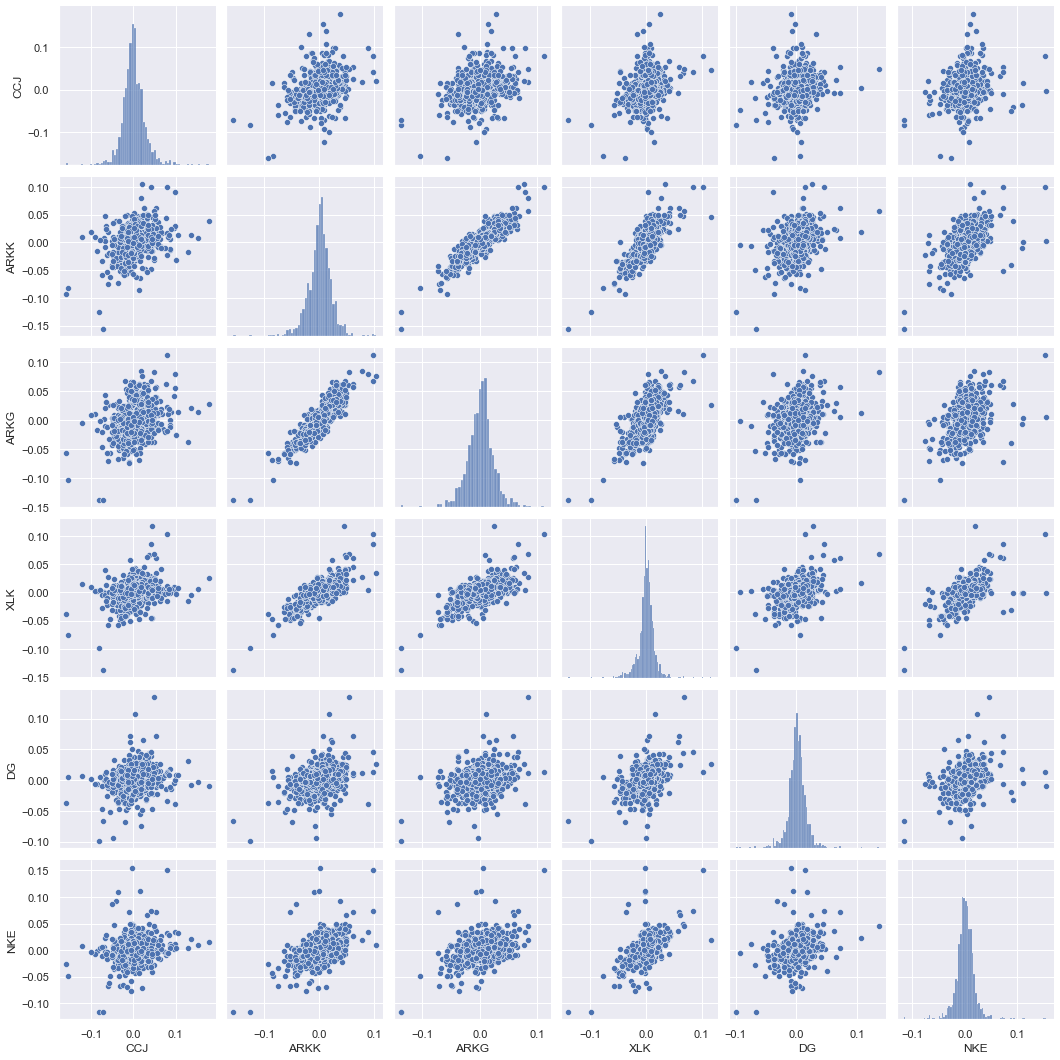

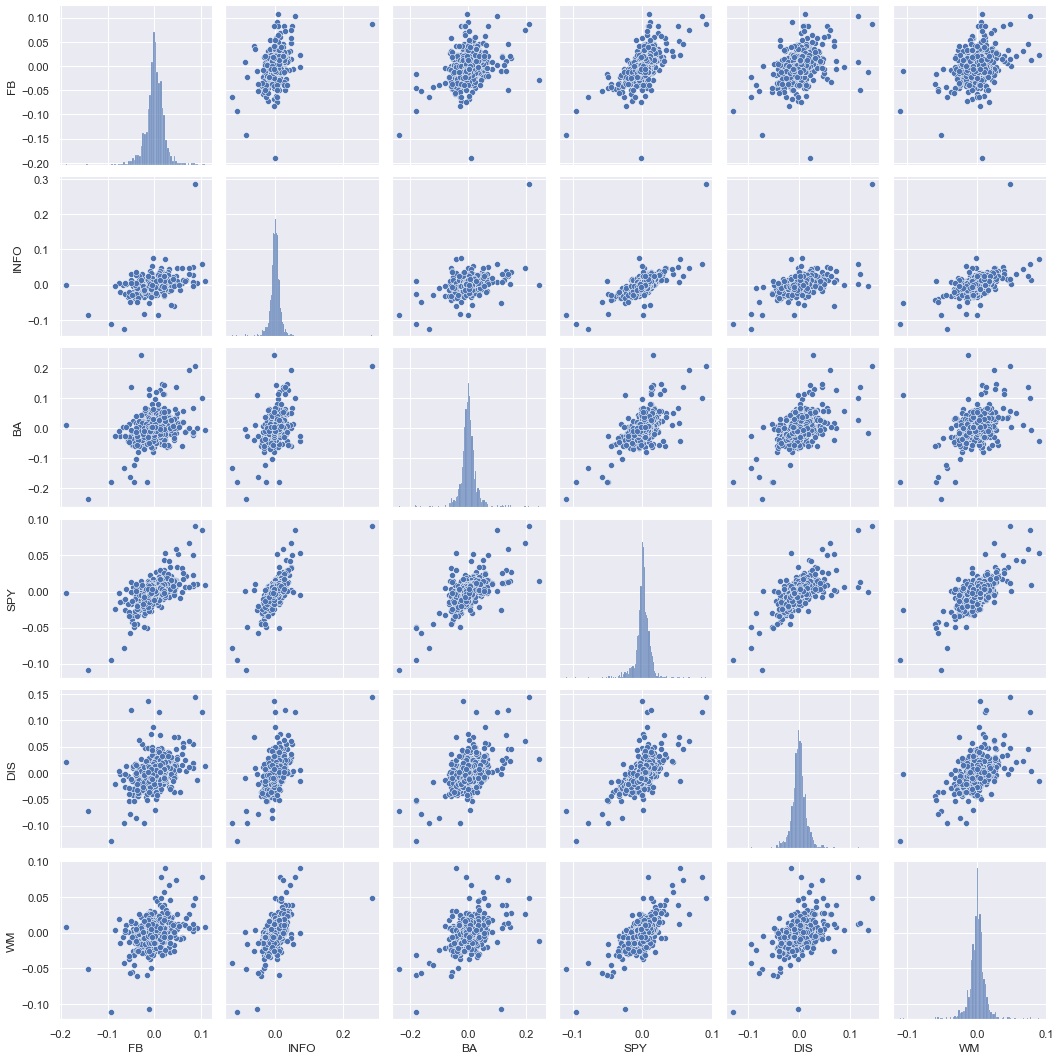

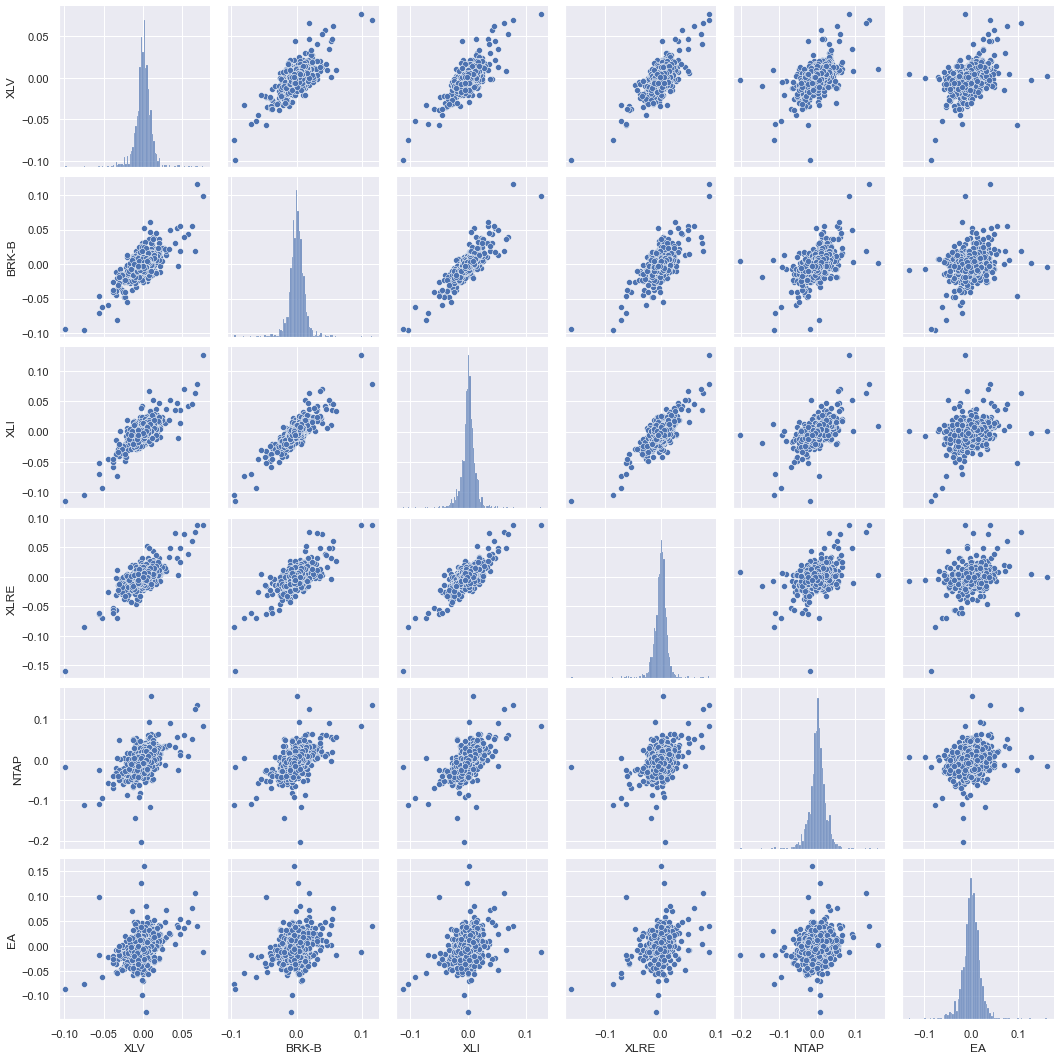

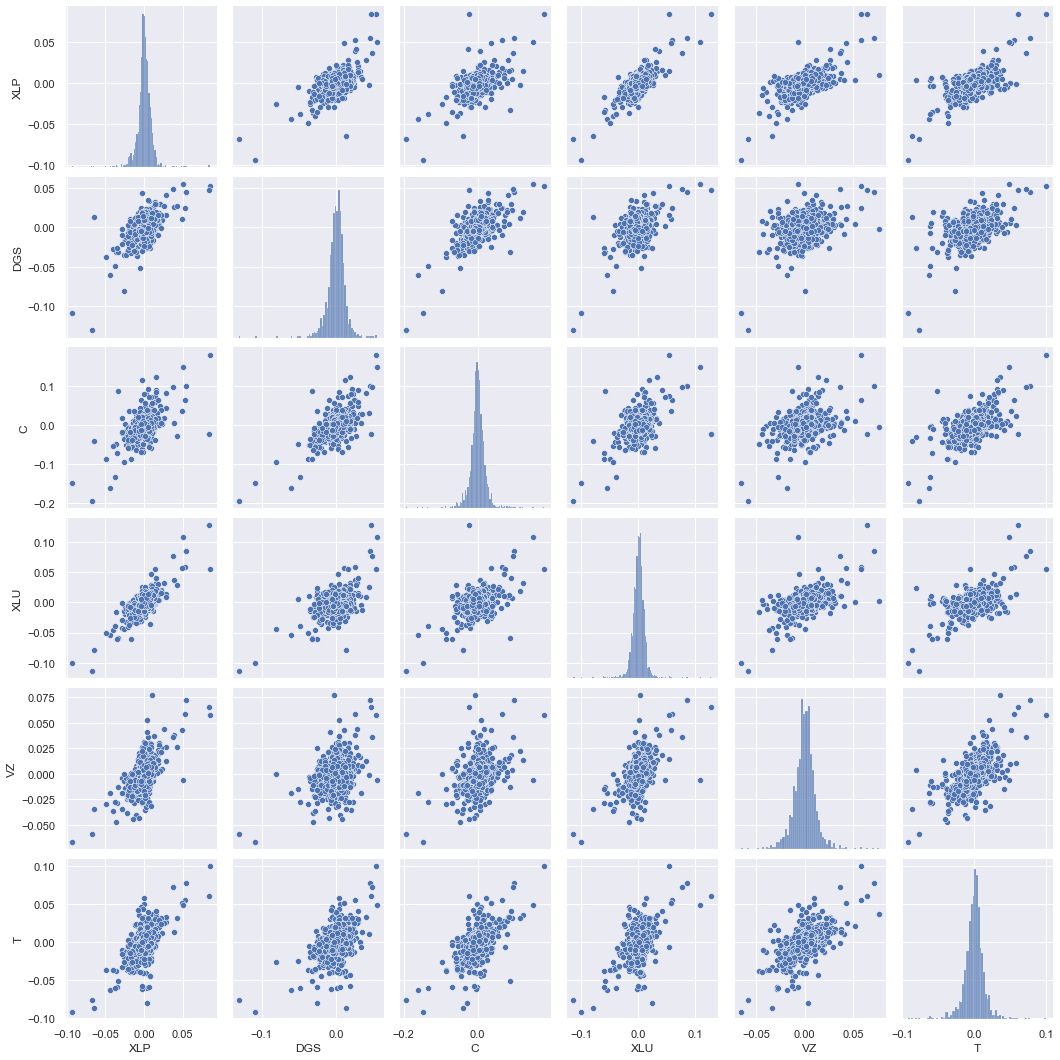

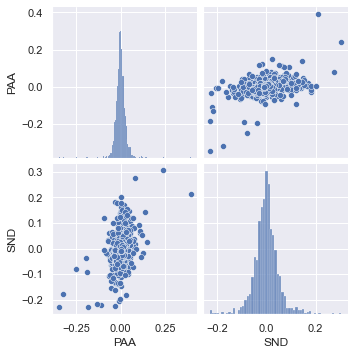

In [105]:
#Plotting the distributions for each name in SHEF
sns.set(color_codes=True)
sns_paiplot1 = sns.pairplot(data = daily_percent_change, vars = daily_percent_change.columns[0:6], diag_kind='hist');
sns_paiplot2 = sns.pairplot(data = daily_percent_change, vars = daily_percent_change.columns[6:12], diag_kind='hist');
sns_paiplot3 = sns.pairplot(data = daily_percent_change, vars = daily_percent_change.columns[12:18], diag_kind='hist');
sns_paiplot4 = sns.pairplot(data = daily_percent_change, vars = daily_percent_change.columns[18:24], diag_kind='hist');
sns_paiplot4 = sns.pairplot(data = daily_percent_change, vars = daily_percent_change.columns[24:], diag_kind='hist');

In [106]:
#Portfolio historiocal variance and std deviation 
covariance_matrix = daily_percent_change.cov()*252 
port_weights = ticker_weights['Weight in the portfolio']
portfolio_volatility_historical =np.sqrt(np.dot(port_weights.T, np.dot(covariance_matrix, port_weights)))

portfolio_volatility_historical

0.20580110175366773

In [139]:
########## Historical VaR 95 ###############

daily_balance['percent_change']= daily_balance['balance'].pct_change()
portfolio_returns = daily_balance['percent_change'][1:]


historical_var_95 = np.percentile(portfolio_returns, 5)

returns_sorted = sorted(portfolio_returns, reverse=False)
#plt.hist(returns_sorted, density=True, stacked=True)
#plt.axvline(x=historical_var_95, color='r', linestyle ='-', label = 'Historical VaR(95) {0:.2f}%'.format(historical_var_95));

print(f'Historical VaR(95) is {round(100*historical_var_95,2)},% \nResulting in a ${aum*historical_var_95:,.0f} loss')

Historical VaR(95) is -1.21,% 
Resulting in a $-9,587 loss


In [140]:
########################## Parametric VaR 95 #################
mu = portfolio_returns.mean()*252
vol = np.std(portfolio_returns)
vol = np.sqrt(252)*vol
t= 1

confidence_level = .05
parametric_var_95 = norm.ppf(confidence_level, mu, vol)

returns_sorted = sorted(portfolio_returns)
#plt.hist(returns_sorted, density=False)
#plt.hist(returns_sorted, density=True, stacked=True)
#plt.axvline(x=parametric_var_95, color='r', linestyle ='-', label = 'Parametric Var95 {0:.2f}%'.format(parametric_var_95));

print(f'Parametric VaR(95) is {round(100*parametric_var_95,2)},% \nResulting in a ${aum*parametric_var_95:,.0f} loss')


Parametric VaR(95) is -17.37,% 
Resulting in a $-137,944 loss


In [145]:
################ Monte Carlo VaR 95 ###############

simulations = []
for i in range(100):
    random_returns = np.random.normal(mu,vol,t)
    simulations.append(random_returns)
monte_carlo_var_95 = np.percentile(simulations, 5)

#plt.hist(returns_sorted, density=True, stacked=True)
#plt.axvline(x=monte_carlo_var_95, color='r', linestyle ='-', label = 'Var 95 {0:.2f}%'.format(monte_carlo_var_95));

print(f'Monte Carlo VaR(95) is {round(100*monte_carlo_var_95,2)},% \nResulting in a ${aum*monte_carlo_var_95:,.0f} loss')

Monte Carlo VaR(95) is -19.25,% 
Resulting in a $-152,806 loss


In [110]:
####### COnditional VaR #########
p = t.fit(daily_balances)






AttributeError: 'int' object has no attribute 'fit'

In [ ]:
######## Summary of SHEF #############

#print(f'Summary of South Hill Equity fund: AUM: ${aum.2f} Volatility: {portfolio_volatility_historical} Historical VaR: {var_historical.2f}, Parametric VaR: {var_parametric}, Monte Carlo VaR: {var_mc}')' )
display('---------------Positons of the SHEF--------------')
display(positions)

#Performance metrics
display('-----------Performance Metrics--------------')
display(cumulative_returns_plot)
display(aum_plot)
display(cumulative_returns_sn)

#Risk metrics 
display('----------------------------Risk Metrics---------------')
display('---------------Box Plot Distributions----------------')
display(box_plot_portfolio_names)
display(sharpe_ratios_plot)
display('---------------Correlaltions across the SHEF----------------')
display(correlations)
display(correlation_heatmap)

display('-----------------Betas for each name in SHEF-------------')
display(shf_betas)

display('---------------Value at Risk (VaR) ----------------')

display('VaR Calculatons')
display('Historical VaR(95) is', round(100*historical_var_95,2),'%')
display('Parametric VaR(95) is', round(100*parametric_var_95,2),'%')
display('Monte Carlo VaR is', round(100*monte_carlo_var_95,2),'%')

display('-----------Historical VaR (95) Distribution---------')
#plt.hist(returns_sorted, density=True, stacked=True)
#plt.axvline(x=historical_var_95, color='r', linestyle ='-', label = 'Var 95 {0:.2f}%'.format(historical_var_95));

display('Marginal Distributions and Scatterplot for each positon in SHEF')
display(sns_paiplot1 = sns.pairplot(data = daily_percent_change, vars = daily_percent_change.columns[0:6], diag_kind='hist'))
display(sns_paiplot2 = sns.pairplot(data = daily_percent_change, vars = daily_percent_change.columns[6:12], diag_kind='hist'))
display(sns_paiplot3 = sns.pairplot(data = daily_percent_change, vars = daily_percent_change.columns[12:18], diag_kind='hist'))
display(sns_paiplot4 = sns.pairplot(data = daily_percent_change, vars = daily_percent_change.columns[18:24], diag_kind='hist'))
display(sns_paiplot4 = sns.pairplot(data = daily_percent_change, vars = daily_percent_change.columns[24:], diag_kind='hist'))






#VaR and Shock analysis 
#monte carlo var 
#shock analysis 

